# Batina Advanced Weight Recovery

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.


In [1]:
import pathlib
TEST_RESULT_DIR = './results'

pathlib.Path(TEST_RESULT_DIR).mkdir(parents=True, exist_ok=True) 

In [2]:
import sys
sys.path.append("../")

from pybatina.advanced_weight_recovery import *
from pybatina.utils import *

In [3]:
import numpy as np
import pandas as pd

guess_range=(-5.0, 5.0)
# the number of guess values in the guess range
secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = -0.2499980926513672
secret_number = int_to_float(float_to_int(secret_number))
print('secret_number =', secret_number)

secret_number = -0.2499980926513672


In [4]:
number_of_best_candidates = 30
awr = AdvancedWeightRecovery(guess_range=guess_range, number_of_best_candidates=number_of_best_candidates)

## ONE STEP

In [5]:
%%time
secret_hamming_weight_set = [np.vectorize(hamming_weight)(input_values * secret_number) for input_values in awr.input_value_set]    
s = awr.recover_weight(secret_hamming_weight_set)
s

../pybatina/advanced_weight_recovery.py:246: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
../pybatina/advanced_weight_recovery.py:246: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= self.guess_range[0], guess_numbers <= self.guess_range[1]))]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 20.4 s, sys: 578 ms, total: 21 s
Wall time: 21 s


-0.249998    1.000000
-0.249998    0.934803
-0.249998    0.849665
-0.249966    0.656329
-0.000976    0.651481
-0.249966    0.617455
-0.248962    0.606568
-0.248957    0.597982
-0.249966    0.596564
-0.248960    0.577939
-0.248959    0.536556
-0.249901    0.513163
-0.249901    0.511695
-0.248993    0.460368
-0.249901    0.425517
-0.248957    0.419244
-0.248957    0.338341
-0.248993    0.321364
-0.247956    0.227499
-0.246131    0.174498
-0.248993    0.144913
-0.246131    0.065311
-0.246130    0.062325
-0.246140    0.002353
-0.246369   -0.055932
-0.246369   -0.057602
-0.246368   -0.088900
-0.244172   -0.094580
-0.125992   -0.117748
-0.125992   -0.123032
dtype: float64

In [6]:
x = secret_number
print('{:032b}'.format(float_to_int(x)), x)

idx = 0
x = s.index[idx]
print('{:032b}'.format(float_to_int(x)), x, s.iloc[idx])

10111110011111111111111110000000 -0.2499980926513672
10111110011111111111111110000000 -0.2499980926513672 1.0


## STEP-BY-STEP

### Correlation of mantissa

In [7]:
%%time

def mantissa_hamming_weight(f):
    AdvancedWeightRecovery.get_mask(component='mantissa', mantissa_byte_index=range(mantissa_byte_index + 1))

numbers = None
mantissa_correlations = {}
known_inputs = awr.build_input_values(component='mantissa')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number).astype(np.float32)
for mantissa_byte_index in range(len(AdvancedWeightRecovery.MANTISSA_THREE_BYTES)):    
    guess_numbers = awr.build_guess_values(component='mantissa', mantissa_byte_index=mantissa_byte_index, numbers=numbers)
    mantissa_corr = awr.compute_corr_numbers(secret_hw, known_inputs, guess_numbers)
    mantissa_correlations[mantissa_byte_index] = mantissa_corr
    groups = AdvancedWeightRecovery.group_candidates(component='mantissa',
                                                     mantissa_byte_index=mantissa_byte_index,
                                                     correlations=mantissa_corr)
    best_groups = (groups[AdvancedWeightRecovery.CORRELATION_STR].mean() > mantissa_corr.mean())
    group_idx = best_groups.index[best_groups==True]
    n_candidates_per_group = max(round(awr.number_of_best_candidates * 2 / len(group_idx)), 3)
    df = pd.DataFrame()
    for idx, g in groups:
        if idx in group_idx:
            df = pd.concat([df, g.sort_values(AdvancedWeightRecovery.CORRELATION_STR, ascending=False).iloc[:n_candidates_per_group]])
    numbers = df.sort_values(AdvancedWeightRecovery.CORRELATION_STR, ascending=False)[AdvancedWeightRecovery.GUESS_VALUE_STR][:awr.number_of_best_candidates]   

CPU times: user 18.5 s, sys: 576 ms, total: 19.1 s
Wall time: 19.1 s


10111110011111111111111110000000 -0.2499980926513672 ----------
00111111111111010000000000000000 1.9765625 -0.1777532629591874
10111110011111111111111110000000 -0.2499980926513672 ----------
00111111111111111111011100000000 1.999725341796875 0.04536240059262756
10111110011111111111111110000000 -0.2499980926513672 ----------
00111111111111111111111110000000 1.9999847412109375 0.1135429069067933


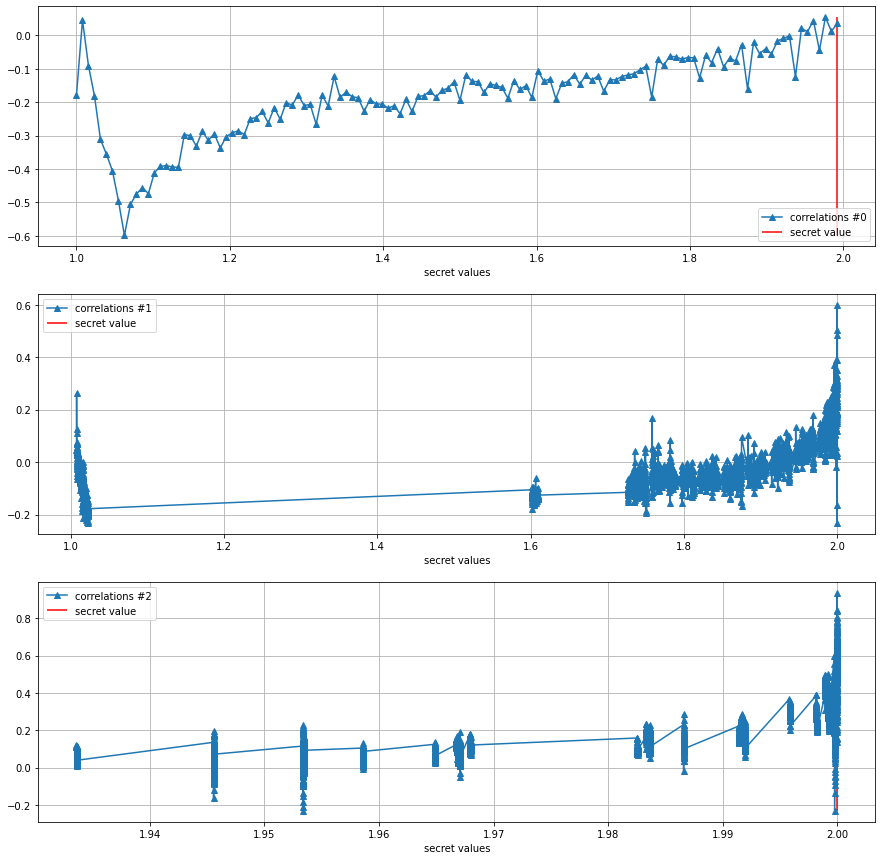

In [8]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(nrows=len(mantissa_correlations), ncols=1, figsize=(15, 5 * len(mantissa_correlations)))
for idx in range(len(mantissa_correlations)):
    corr = mantissa_correlations[idx].sort_index()
    corr.plot(ax=ax[idx], label='correlations #%d' % idx, kind='line', marker='^')  
    x = int_to_float(((float_to_int(abs(secret_number)) 
                       & AdvancedWeightRecovery.get_mask('mantissa', range(idx + 1)))
                      & (AdvancedWeightRecovery.get_mask('exponent') ^ 0xFFFFFFFF))
                     | (127<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS))
    ax[idx].vlines(x, corr.min(), corr.max(), color='red', label='secret value')
    ax[idx].legend()
    ax[idx].grid(True)
    ax[idx].set_xlabel('secret values')
    
    x = secret_number
    print('{:032b}'.format(float_to_int(x)), x, '-' * 10)
    x = mantissa_correlations[idx].idxmax()
    print('{:032b}'.format(float_to_int(x)), x, mantissa_correlations[idx].iloc[0])

In [9]:
mantissa_correlations[1].sort_values(ascending=False)

1.999725    0.598846
1.999207    0.504209
1.999969    0.482947
1.998932    0.390950
1.998169    0.388105
              ...   
1.020630   -0.222764
1.023071   -0.223405
1.021606   -0.227591
1.022583   -0.231156
1.999756   -0.232728
Length: 7680, dtype: float64

# sign

In [10]:
numbers = np.asarray(numbers)
positive_corr = awr.compute_corr_numbers(secret_hw=secret_hw, known_inputs=known_inputs, guess_numbers=numbers)
negative_corr = awr.compute_corr_numbers(secret_hw=secret_hw, known_inputs=known_inputs, guess_numbers=-numbers)

In [11]:
corr = positive_corr
if positive_corr.sum() < negative_corr.sum():
    numbers = -numbers
    corr = negative_corr
numbers

array([-1.99998474, -1.99998486, -1.99998462, -1.99998498, -1.9999845 ,
       -1.99972534, -1.99972546, -1.99972558, -1.99920654, -1.9997257 ,
       -1.99894726, -1.99894691, -1.99972582, -1.99920678, -1.99894702,
       -1.99894679, -1.99920666, -1.99894655, -1.9992069 , -1.99920702,
       -1.99816942, -1.9981693 , -1.99816895, -1.99816918, -1.99581909,
       -1.99581921, -1.99583375, -1.99816966, -1.99584866, -1.99583352])

Text(0.5, 0, 'secret values')

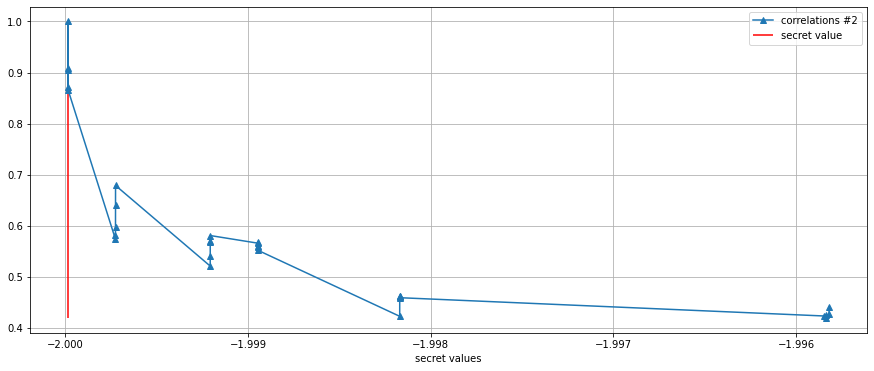

In [12]:
from matplotlib import pyplot as plt
ax = corr.sort_index().plot(label='correlations #%d' % idx, figsize=(15,6), marker='^')
x = int_to_float((float_to_int(secret_number) & ~(0xff<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS)) | (127<<AdvancedWeightRecovery.MAX_MANTISSA_NBITS))
ax.vlines(x, corr.min(), corr.max(), color='red', label='secret value')
ax.legend()
ax.grid(True)
ax.set_xlabel('secret values')

### Correlation exponent

In [13]:
%%time
known_inputs = awr.build_input_values(component='exponent')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)

mantisa_exp_corr = pd.Series()
guess_numbers = AdvancedWeightRecovery.build_guess_values(component='exponent', numbers=numbers)
guess_numbers = guess_numbers[np.where(np.logical_and(guess_numbers >= guess_range[0], guess_numbers <= guess_range[1]))]
mantisa_exp_corr = AdvancedWeightRecovery.compute_corr_numbers(secret_hw, known_inputs, guess_numbers).sort_values(ascending=False).iloc[:awr.number_of_best_candidates]

groups = AdvancedWeightRecovery.group_candidates(component='exponent', correlations=mantisa_exp_corr)
best_groups = (groups[AdvancedWeightRecovery.CORRELATION_STR].mean() > mantissa_corr.mean())
group_idx = best_groups.index[best_groups==True]
n_candidates_per_group = max(round(awr.number_of_best_candidates * 2 / len(group_idx)), 3)
df = pd.DataFrame()
for idx, g in groups:
    if idx in group_idx:
        df = pd.concat([df, g.sort_values(AdvancedWeightRecovery.CORRELATION_STR, ascending=False).iloc[:n_candidates_per_group]])
numbers = df.sort_values(AdvancedWeightRecovery.CORRELATION_STR, ascending=False)[AdvancedWeightRecovery.GUESS_VALUE_STR][:awr.number_of_best_candidates]

# get the best values
mantisa_exp_corr.sort_values(ascending=False, inplace=True)
numbers = np.asarray(mantisa_exp_corr.index[:awr.number_of_best_candidates])

<timed exec>:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
<timed exec>:6: RuntimeWarning: invalid value encountered in greater_equal
<timed exec>:6: RuntimeWarning: invalid value encountered in less_equal
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 1.58 s, sys: 43.9 ms, total: 1.63 s
Wall time: 1.63 s


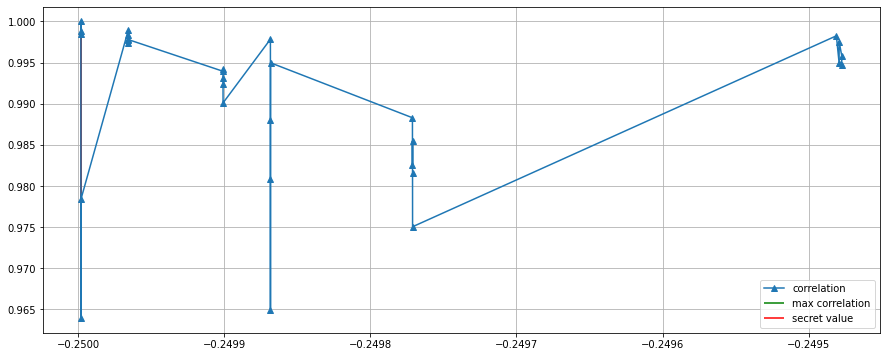

In [14]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6), label='correlation', marker='^')
ax.vlines(mantisa_exp_corr.idxmax(), mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

In [15]:
mantisa_exp_corr.iloc[:awr.number_of_best_candidates]

-0.249998    1.000000
-0.249966    0.998916
-0.249998    0.998856
-0.249998    0.998535
-0.249966    0.998369
-0.249481    0.998255
-0.249966    0.997839
-0.249868    0.997839
-0.249966    0.997797
-0.249479    0.997545
-0.249966    0.997379
-0.249477    0.995817
-0.249479    0.994976
-0.249868    0.994976
-0.249477    0.994745
-0.249901    0.994194
-0.249901    0.993947
-0.249901    0.993172
-0.249901    0.992420
-0.249901    0.990101
-0.249771    0.988295
-0.249868    0.988050
-0.249771    0.985483
-0.249771    0.982590
-0.249771    0.981589
-0.249868    0.980821
-0.249998    0.978391
-0.249771    0.975047
-0.249868    0.964961
-0.249998    0.963956
dtype: float64

### Last sorting

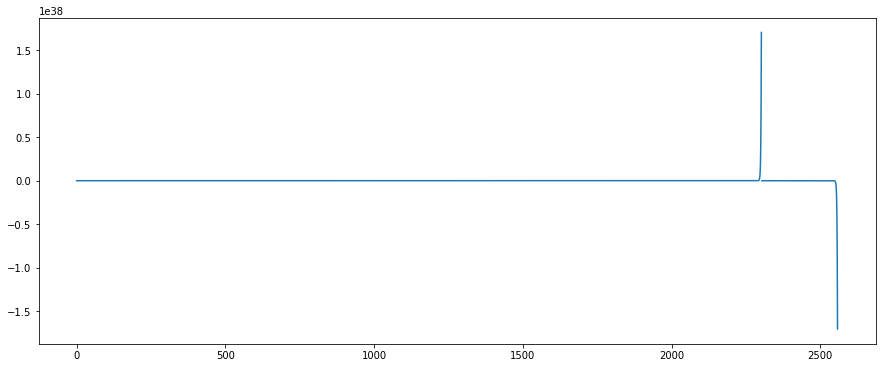

In [16]:
known_inputs = np.concatenate((awr.build_input_values(component='mantissa'), awr.build_input_values(component='exponent')))
#known_inputs = np.random.uniform(-1, 1, 1000)
#known_inputs = awr.build_input_values(component='mantissa')
#known_inputs = awr.build_input_values(component='exponent')

secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number).astype(np.float32)
full_corr = AdvancedWeightRecovery.compute_corr_numbers(secret_hw, known_inputs, numbers).sort_values(ascending=False)
pd.Series(known_inputs).plot(figsize=(15, 6))

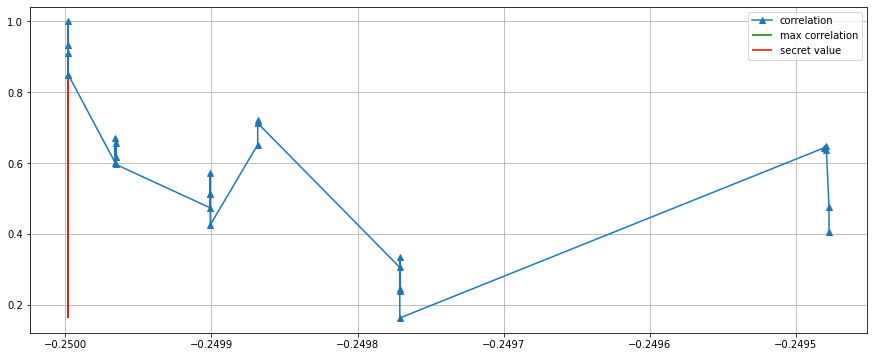

In [17]:
ax = full_corr.sort_index().plot(figsize=(15,6), label='correlation', marker='^')
ax.vlines(full_corr.idxmax(), full_corr.min(), full_corr.max(), color='green', label='max correlation')
ax.vlines(secret_number, full_corr.min(), full_corr.max(), color='red', label='secret value')
ax.legend()
ax.grid()

### Result

In [18]:
x = secret_number
print('{:032b}'.format(float_to_int(x)), x)

idx = 0
x = full_corr.index[idx]
print('{:032b}'.format(float_to_int(x)), x, full_corr.iloc[idx])

10111110011111111111111110000000 -0.2499980926513672
10111110011111111111111110000000 -0.2499980926513672 1.0


In [19]:
print('secret_number:', secret_number)
print('the best guessed value:', full_corr.index[0], 'Correlation:', full_corr.iloc[0])

secret_number: -0.2499980926513672
the best guessed value: -0.2499980926513672 Correlation: 1.0


In [20]:
full_corr

-0.249998    1.000000
-0.249998    0.934803
-0.249998    0.910649
-0.249998    0.849929
-0.249998    0.849665
-0.249868    0.722233
-0.249868    0.717127
-0.249868    0.712489
-0.249868    0.712206
-0.249966    0.670701
-0.249966    0.656329
-0.249868    0.651773
-0.249479    0.649621
-0.249481    0.642561
-0.249479    0.637300
-0.249966    0.617455
-0.249966    0.599499
-0.249966    0.596564
-0.249901    0.570792
-0.249901    0.513163
-0.249901    0.511695
-0.249477    0.475327
-0.249901    0.473549
-0.249901    0.425517
-0.249477    0.404341
-0.249771    0.334087
-0.249771    0.305625
-0.249771    0.243270
-0.249771    0.238169
-0.249771    0.162457
dtype: float64

In [21]:
n = 16
i = (((1<<n)-1) << (23-n)) | (124 << 23)
f = int_to_float(i)
print('{:032b}'.format(i), f)

00111110011111111111111110000000 0.2499980926513672
